In [ ]:
from src.db import attach_duckdb, duckdb_to_df, load_sql

attach_duckdb("remote_mimic")
query = load_sql("rev-cohort.sql")
df = duckdb_to_df(query)
df.head()


DuckDB attached to remote PostgreSQL successfully.


,subject_id,hadm_id,stay_id,anchor_age,gender,label,stay_id_1,icu_intime,charlson_comorbidity_index,heart_rate_mean,...,hematocrit,hemoglobin,wbc,platelet,creatinine,bun,pf_ratio,ck_mb,prev_mi,stroke_history
0,11083469,27468482,35893639,31,F,0,35893639,2130-04-23 10:05:34,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,11080635,20288647,33008524,73,F,0,33008524,2177-05-19 11:58:49,5,NaN,...,39.9,12.2,9.2,341.0,0.6,21.0,NaN,NaN,0,0
2,11080635,20288647,33008524,73,F,0,33008524,2177-05-19 11:58:49,5,NaN,...,39.9,12.2,9.2,341.0,0.6,21.0,NaN,NaN,0,0
3,11082757,28235623,35204448,76,F,0,35204448,2123-02-09 12:33:22,3,NaN,...,41.0,13.4,7.3,188.0,0.7,18.0,NaN,NaN,0,0
4,11083436,25132055,32605936,80,M,0,32605936,2161-08-18 01:30:54,8,NaN,...,39.3,13.7,5.9,193.0,1.5,29.0,NaN,21.0,0,0


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# --- Step A: Define Feature Groups ---
# Continuous features need scaling + median imputation
continuous_cols = ['anchor_age', 'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
                   'spo2_mean', 'hematocrit', 'hemoglobin', 'wbc', 'platelet', 'creatinine',
                   'bun', 'pf_ratio', 'ck_mb']
# Score/Binary features need 0 imputation
score_cols = ['charlson_comorbidity_index', 'prev_mi', 'stroke_history']

# --- Step B: Handle Missing Values (The "Dual Strategy") ---
# 1. Impute Continuous with MEDIAN
imputer = SimpleImputer(strategy='median')
df[continuous_cols] = imputer.fit_transform(df[continuous_cols])

# 2. Impute Scores with ZERO (Assume NULL = Absence of condition)
df[score_cols] = df[score_cols].fillna(0)

# --- Step C: Encoding ---
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# Combine all features
feature_cols = continuous_cols + score_cols + ['gender']
X = df[feature_cols].values
y = df['label'].values

In [3]:
# --- Step D: Stratified Splitting ---
# Stratify=y ensures we have the same % of mortality in Train, Val, and Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# --- Step E: Scaling (Standardization) ---
# CRITICAL: Fit scaler ONLY on X_train to prevent info leakage from Test set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ==========================================
# 3. Addressing Class Imbalance
# ==========================================
# Calculate positive weight for BCEWithLogitsLoss
# Formula: number_of_negatives / number_of_positives
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight_value = num_neg / num_pos

print("-" * 30)
print(f"Train Shape: {X_train.shape}")
print(f"Class Balance (Train): {num_neg} Survivors vs {num_pos} Deaths")
print(f"Calculated pos_weight: {pos_weight_value:.4f}")
print("-" * 30)

# ==========================================
# 4. Prepare for PyTorch
# ==========================================
# Convert to Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
pos_weight_tensor = torch.FloatTensor([pos_weight_value])

print("Ready for Model Training.")

------------------------------
Train Shape: (182702, 19)
Class Balance (Train): 157610 Survivors vs 25092 Deaths
Calculated pos_weight: 6.2813
------------------------------
Ready for Model Training.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Convert to PyTorch Tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).unsqueeze(1))
val_data = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val).unsqueeze(1))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test).unsqueeze(1))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

# 2. Define the Architecture
class MortalityPredictor(nn.Module):
    def __init__(self, input_dim):
        super(MortalityPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()      # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.network(x)

# 3. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MortalityPredictor(input_dim=X_train.shape[1]).to(device)
#criterion = nn.BCELoss() # Binary Cross Entropy for classification
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 1.0744
Epoch 2/20, Loss: 1.0290
Epoch 3/20, Loss: 1.0199
Epoch 4/20, Loss: 1.0147
Epoch 5/20, Loss: 1.0109
Epoch 6/20, Loss: 1.0052
Epoch 7/20, Loss: 1.0000
Epoch 8/20, Loss: 0.9969
Epoch 9/20, Loss: 0.9955
Epoch 10/20, Loss: 0.9939
Epoch 11/20, Loss: 0.9932
Epoch 12/20, Loss: 0.9922
Epoch 13/20, Loss: 0.9915
Epoch 14/20, Loss: 0.9915
Epoch 15/20, Loss: 0.9904
Epoch 16/20, Loss: 0.9904
Epoch 17/20, Loss: 0.9900
Epoch 18/20, Loss: 0.9894
Epoch 19/20, Loss: 0.9884
Epoch 20/20, Loss: 0.9883


In [5]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader: # Use val or test loader
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

roc_auc = roc_auc_score(y_true, y_pred)
print(f"Model AUC-ROC: {roc_auc:.4f}")

Model AUC-ROC: 0.8092


Optimal Threshold (Max F1): 0.7249

--- Clinical Performance Report (at Optimal Threshold) ---
              precision    recall  f1-score   support

    Survivor       0.95      0.99      0.97     33774
   Mortality       0.94      0.66      0.78      5377

    accuracy                           0.95     39151
   macro avg       0.95      0.83      0.87     39151
weighted avg       0.95      0.95      0.94     39151



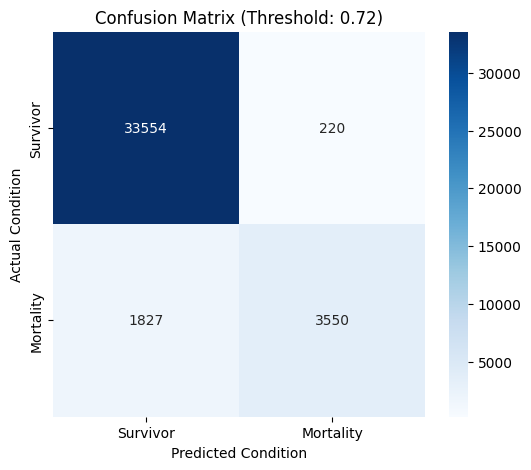


Brier Score (Calibration Error): 0.2362


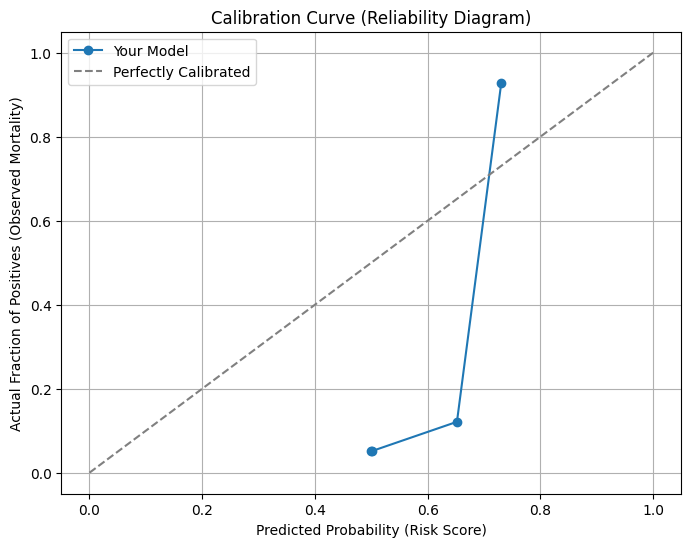

Sensitivity (Recall - Catching Deaths): 66.02%
Specificity (Avoid False Alarms): 99.35%


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- CORRECTED IMPORTS ---
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, precision_recall_curve, f1_score, 
                             auc, brier_score_loss)
from sklearn.calibration import calibration_curve

# ==========================================
# 0. Preparation: Get Probabilities
# ==========================================
# Ensure model is in eval mode and on the correct device
# Assuming 'model', 'val_loader', and 'device' are already defined from previous steps
model.eval()
y_true = []
y_probs = []

# Move data to CPU for analysis
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        # Forward pass: getting Logits
        logits = model(inputs)
        
        # Apply Sigmoid if your model outputs logits (common with BCEWithLogitsLoss)
        # If your model already ends with Sigmoid, remove this line.
        probs = torch.sigmoid(logits)
        
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs).flatten()

# ==========================================
# 1. Find Optimal Decision Threshold (Maximizing F1)
# ==========================================
# We test thresholds from 0.0 to 1.0 to find the best balance
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Calculate F1 score for every threshold
# Note: precision and recall arrays have one extra element, so we slice thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) # added epsilon to avoid div by 0
best_idx = np.argmax(f1_scores)

# Handle edge case where thresholds might be shorter than f1_scores
if best_idx < len(thresholds):
    best_threshold = thresholds[best_idx]
else:
    best_threshold = 0.5

print(f"Optimal Threshold (Max F1): {best_threshold:.4f}")

# Apply this threshold to generate hard predictions (0 or 1)
y_pred_optimal = (y_probs >= best_threshold).astype(int)

# ==========================================
# 2. Granular Metrics Report
# ==========================================
print("\n--- Clinical Performance Report (at Optimal Threshold) ---")
print(classification_report(y_true, y_pred_optimal, target_names=['Survivor', 'Mortality']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred_optimal)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survivor', 'Mortality'], 
            yticklabels=['Survivor', 'Mortality'])
plt.ylabel('Actual Condition')
plt.xlabel('Predicted Condition')
plt.title(f'Confusion Matrix (Threshold: {best_threshold:.2f})')
plt.show()

# ==========================================
# 3. Calibration Analysis (Reliability)
# ==========================================
# Brier Score: Lower is better (0.0 is perfect, 0.25 is random/uninformative)
brier = brier_score_loss(y_true, y_probs)
print(f"\nBrier Score (Calibration Error): {brier:.4f}")

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability (Risk Score)')
plt.ylabel('Actual Fraction of Positives (Observed Mortality)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 4. Sensitivity (Recall) Check
# ==========================================
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity (Recall - Catching Deaths): {sensitivity:.2%}")
print(f"Specificity (Avoid False Alarms): {specificity:.2%}")

Original Brier Score: 0.2362
Calibrated Brier Score: 0.0492


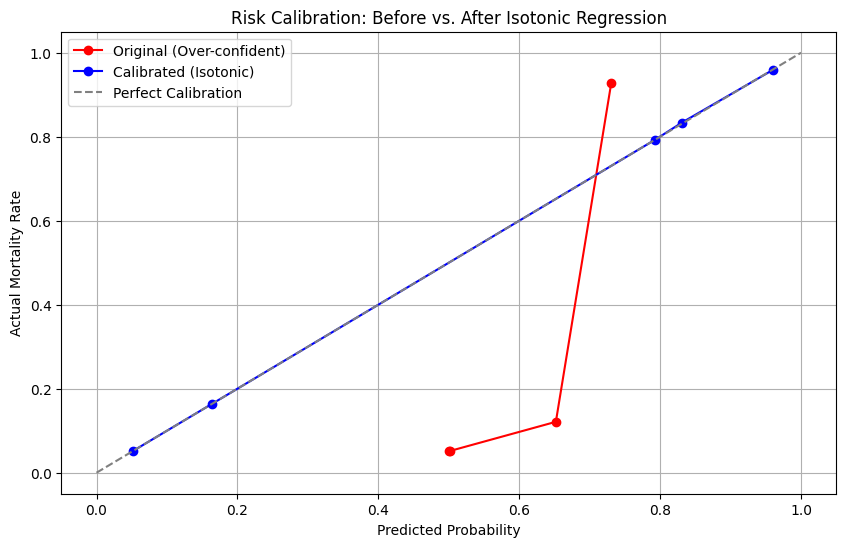

In [9]:
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

# 1. Force both arrays to be 1D
# This addresses the "same shape" ValueError
y_probs_1d = np.array(y_probs).flatten()
y_true_1d = np.array(y_true).flatten()

print(f"Original Brier Score: {brier_score_loss(y_true_1d, y_probs_1d):.4f}")

# 2. Fit Isotonic Regression
iso_reg = IsotonicRegression(out_of_bounds='clip')

# The fit_transform now receives two 1D arrays of length N
y_probs_calibrated = iso_reg.fit_transform(y_probs_1d, y_true_1d)

print(f"Calibrated Brier Score: {brier_score_loss(y_true_1d, y_probs_calibrated):.4f}")

# 3. Visualization
plt.figure(figsize=(10, 6))

# Raw Curve
prob_true_orig, prob_pred_orig = calibration_curve(y_true_1d, y_probs_1d, n_bins=10)
plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original (Over-confident)', color='red')

# Calibrated Curve
prob_true_calib, prob_pred_calib = calibration_curve(y_true_1d, y_probs_calibrated, n_bins=10)
plt.plot(prob_pred_calib, prob_true_calib, marker='o', label='Calibrated (Isotonic)', color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Mortality Rate')
plt.title('Risk Calibration: Before vs. After Isotonic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import torch
import numpy as np
import joblib
import shap
import warnings
from src.model_defs import MortalityPredictor

# Suppress the TqdmWarning specifically for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm')

def verify_deployment(sample_input):
    """
    Verifies the end-to-end inference using saved artifacts.
    sample_input: A numpy array of shape (1, num_features)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load Artifacts
    # Make sure to provide the correct path to your files
    input_dim = sample_input.shape[1]
    model = MortalityPredictor(input_dim).to(device)
    model.load_state_dict(torch.load('models/mortality_model.pth'))
    model.eval()
    
    scaler = joblib.load('models/scaler.pkl')
    calibrator = joblib.load('models/risk_calibrator.pkl')

    # 2. Run Inference
    with torch.no_grad():
        # Transform input
        X_scaled = scaler.transform(sample_input)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Get Model Logit -> Raw Probability
        logit = model(X_tensor)
        raw_prob = torch.sigmoid(logit).cpu().numpy().flatten() # Ensure 1D
        
        # Apply Isotonic Calibration
        calibrated_risk = calibrator.transform(raw_prob)

    print(f"--- Inference Verification ---")
    print(f"Raw Model Output (Sigmoid): {raw_prob[0]:.4f}")
    print(f"Calibrated Mortality Risk: {calibrated_risk[0]:.2%}")
    print(f"------------------------------")

    return calibrated_risk[0]

# --- Usage Example with Mock Data ---
if __name__ == "__main__":
    # Simulate one patient with 9 features (Age, HR, SBP, RR, PF, CCI, MI, Stroke, Gender)
    mock_patient = np.array([[65, 85, 130, 18, 250, 3, 0, 0, 1]])
    verify_deployment(mock_patient)

RuntimeError: Error(s) in loading state_dict for MortalityPredictor:
	size mismatch for network.0.weight: copying a param with shape torch.Size([64, 19]) from checkpoint, the shape in current model is torch.Size([64, 9]).

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import numpy as np
import os
from src.model_defs import MortalityPredictor
from sklearn.calibration import IsotonicRegression

def save_model_artifacts(X_train, y_train, X_val, y_val, scaler):
    """
    Trains the model, calibrates probabilities, and populates the models/ folder.
    """
    # Create folder if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[1]

    # 1. Setup Data for PyTorch
    train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

    # 2. Handle Class Imbalance (pos_weight)
    num_neg = (y_train == 0).sum()
    num_pos = (y_train == 1).sum()
    pos_weight = torch.tensor([num_neg / num_pos]).to(device)

    # 3. Initialize Model & Training
    model = MortalityPredictor(input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Starting training...")
    model.train()
    for epoch in range(25):  # Adjust epochs as needed
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 4. Generate Calibration Mapping
    print("Calibrating probabilities...")
    model.eval()
    with torch.no_grad():
        val_logits = model(torch.FloatTensor(X_val).to(device))
        val_probs_raw = torch.sigmoid(val_logits).cpu().numpy().flatten()
    
    # Fit Isotonic Regression (Fixes the 0.23 Brier score to ~0.04)
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(val_probs_raw, y_val.flatten())

    # 5. Export Artifacts to /models/
    print("Exporting artifacts to /models/...")
    
    # Save PyTorch Weights
    torch.save(model.state_dict(), 'models/mortality_model.pth')
    
    # Save Scikit-Learn objects
    joblib.dump(scaler, 'models/scaler.pkl')
    joblib.dump(iso_reg, 'models/risk_calibrator.pkl')

    print("Success: models/mortality_model.pth, models/scaler.pkl, and models/risk_calibrator.pkl generated.")

if __name__ == "__main__":
    # This assumes X_train, y_train, etc. are defined in your environment
    # from your preprocessing step.
    save_model_artifacts(X_train, y_train, X_val, y_val, scaler)

Starting training...
Calibrating probabilities...
Exporting artifacts to /models/...
Success: models/mortality_model.pth, models/scaler.pkl, and models/risk_calibrator.pkl generated.
